In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx
from src.data.dataload import load_csv_folder_to_dataframe

In [2]:
## get data and preprocess
DATA_DIR = "data/raw"
df_loaded = load_csv_folder_to_dataframe(DATA_DIR)

#only tübingen data
df_tue = df_loaded[df_loaded['domain_name']=='Stadt Tübingen']
df_tue['iso_timestamp'] = pd.to_datetime(df_tue['iso_timestamp'], errors='coerce')

# smaller dataframe
df_tue_small = df_tue[['counter_site', 'iso_timestamp', 'channels_all', 'latitude', 'longitude']].copy()

Loading CSV files: 100%|██████████| 156/156 [03:19<00:00,  1.28s/file]


Load summary
- Files loaded: 156
- Total rows: 6125443
- Date range: 2012-12-31 23:00:00+00:00 to 2025-12-31 22:00:00+00:00
- Unique stations: 129


C:\Users\Crabsi\AppData\Local\Temp\ipykernel_13188\684654053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tue['iso_timestamp'] = pd.to_datetime(df_tue['iso_timestamp'], errors='coerce')


In [3]:
# get nodes dictionary from tübingen data
nodes_dict = {}
for counter_site in df_tue_small['counter_site'].unique():
    df_temp = df_tue_small[df_tue_small['counter_site']==counter_site]
    lat = df_temp['latitude'].values[0]
    lon = df_temp['longitude'].values[0]
    nodes_dict[counter_site] = (lat, lon)
print(nodes_dict)

## center node for tübingen
# latitude
center_lat = mean_lat = df_tue['latitude'].mean()
# longitude
center_lon = mean_lon = df_tue['longitude'].mean()  
center = (center_lat, center_lon)
center

# create mini dataframe
df_nodes = pd.DataFrame(nodes_dict).T
df_nodes.columns = ['lat', 'lon']


{'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee': (np.float64(48.515434), np.float64(9.058865)), 'Fuß- & Radtunnel Südportal - Derendinger Allee': (np.float64(48.518), np.float64(9.04806)), 'Neckartalradweg Hirschau - parallel L371': (np.float64(48.50357), np.float64(9.02496)), 'Radbrücke Mitte - Wöhrdstraße': (np.float64(48.5178), np.float64(9.06091)), 'Radbrücke Ost': (np.float64(48.51824), np.float64(9.06905))}


In [4]:
## omnsx part, first create graph with 3km buffer around center
G = ox.graph_from_point(center, dist=3000, network_type='bike')
# find the nearest node in the graph to the center point
center_node = ox.distance.nearest_nodes(G, X=center[1], Y=center[0])
# calculate shortest path lengths from center_node to all other nodes (we need this later)
lengths = nx.shortest_path_length(G, source=center_node, weight="length")

## then make a subgraph, because its easier to work with
# create a subgraph of all nodes within 3km of the center_node
subG = nx.ego_graph(
    G,
    center_node,
    radius=3000,
    distance="length"
)

# keep only the largest strongly connected components (parts where every node is reachable from every other node)
subG = subG.subgraph(
    max(nx.strongly_connected_components(subG), key=len)
).copy()


In [5]:
# we need some nodes that have to be included (from nodes dict!)
must_include_nodes = []

# find the nearest nodes in the graph for each of the specified lat/lon coordinates
for name, (lat, lon) in nodes_dict.items():
    nearest_node = ox.distance.nearest_nodes(subG, X=lon, Y=lat)
    must_include_nodes.append(nearest_node)

# calculate shortest path lengths from center_node to all other nodes in the subgraph
lengths2 = nx.single_source_dijkstra_path_length(subG, source=center_node, weight="length")

# now sort them by length
candidates = sorted(lengths2, key = lengths2.get)

# we want a minimum distance of 200m between selected nodes
MIN_DIST = 200
selected = []

# greedy selection of nodes ensuring minimum distance
for u in candidates:
    if not selected:
        selected.append(u)
        continue

    near = nx.single_source_dijkstra_path_length(
        subG, source=u, cutoff=MIN_DIST, weight="length"
    )
    if not any(n in near for n in selected):
        selected.append(u)


# our must_include nodes may not be in selected, so we add them now
final_selected = list(selected) 

# just add them to the final list if they are not already included
for n in must_include_nodes:
    if n not in final_selected:
        final_selected.append(n)


In [6]:
for n in must_include_nodes:
    if n not in subG.nodes:
        print("Must-Include Node nicht im Subgraph:", n)
print("Anzahl der ausgewählten Knoten:", len(final_selected))

Anzahl der ausgewählten Knoten: 515


In [7]:
site_to_node = dict(zip(nodes_dict.keys(), must_include_nodes))
df_tue_small['node_id'] = df_tue_small['counter_site'].map(site_to_node)
df_tue_small['graph_dist'] = df_tue_small['node_id'].map(lengths2)
df_tue_small['hour'] = pd.to_datetime(df_tue_small['iso_timestamp']).dt.hour
X = df_tue_small[['graph_dist','hour']].values
y = df_tue_small['channels_all'].values


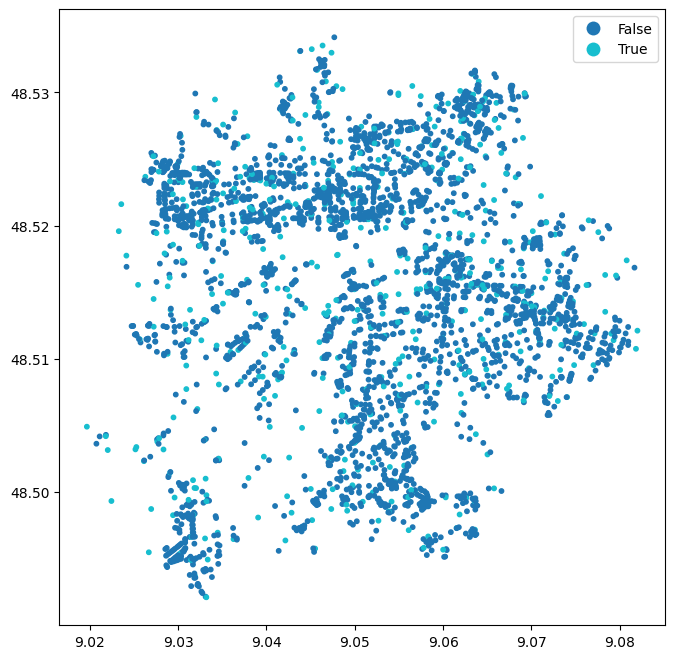

In [8]:
## visualization
# visualize the selected nodes
gdf = ox.graph_to_gdfs(subG, nodes=True, edges=False)
gdf["selected"] = gdf.index.isin(final_selected)

# plot the graph with selected and unselected nodes highlighted
ax = gdf.plot(
    column="selected",
    categorical=True,
    legend=True,
    figsize=(8,8),
    markersize=10
)

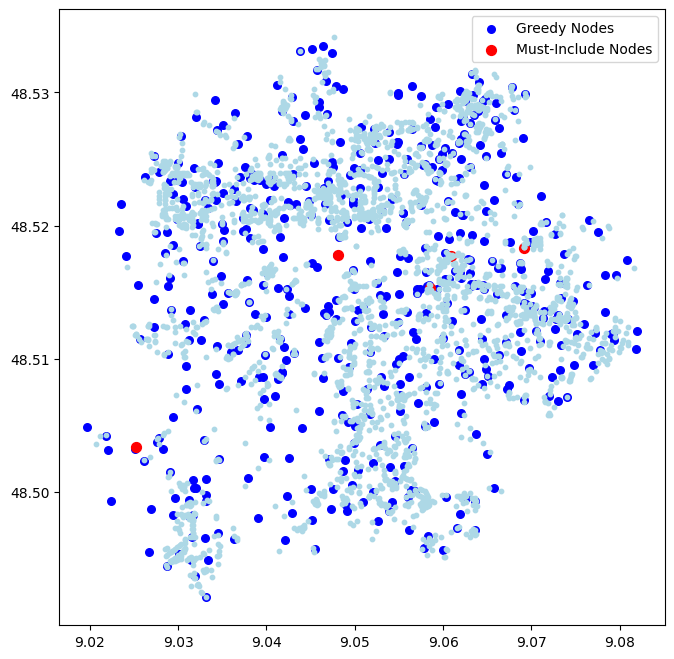

In [9]:
## visualization with selected, must-include and unselected nodes
gdf["greedy_selected"] = gdf.index.isin(selected)
gdf["must_include"] = gdf.index.isin(must_include_nodes)

fig, ax = plt.subplots(figsize=(8,8))
gdf[gdf["greedy_selected"]].plot(ax=ax, color="blue", markersize=30, label="Greedy Nodes")
gdf[gdf["must_include"]].plot(ax=ax, color="red", markersize=50, label="Must-Include Nodes")
gdf[~gdf["greedy_selected"] & ~gdf["must_include"]].plot(ax=ax, color="lightblue", markersize=10)
plt.legend()
plt.show()

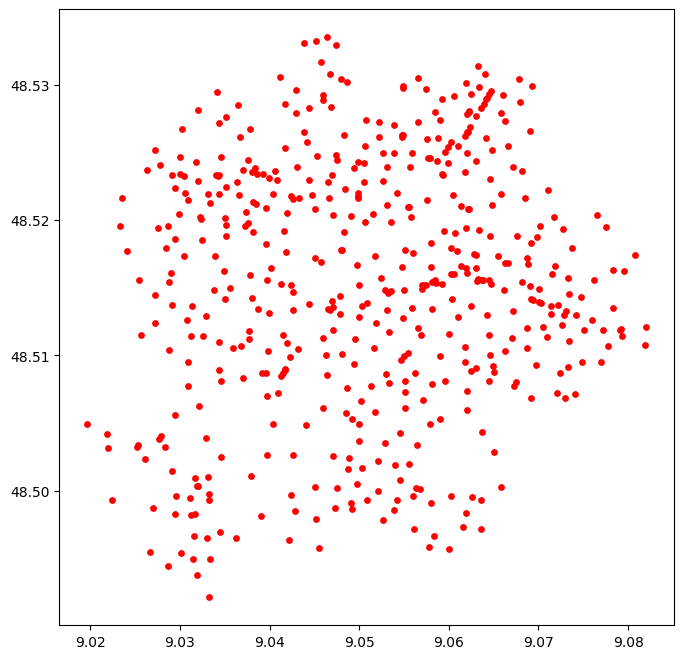

In [10]:
## visualization (only selected)
# plot only the selected nodes
selected_gdf = gdf[gdf["selected"]]

ax = selected_gdf.plot(
    color="red",
    markersize=15,
    figsize=(8,8)
)


In [11]:
lengths = dict(lengths)

drop_keys = [k for k, v in lengths.items() if v < 200]
for k in drop_keys:
    lengths.pop(k)


nodes = ox.graph_to_gdfs(G, edges=False)
print(nodes.head())
nodes["network_distance_m"] = nodes.index.map(lengths)

                  y         x  street_count            highway junction  \
osmid                                                                     
163396    48.517845  9.086956             3                NaN      NaN   
163397    48.520472  9.084872             3                NaN      NaN   
163404    48.515745  9.086860             3                NaN      NaN   
163405    48.514916  9.084301             3  motorway_junction      NaN   
24983135  48.512963  9.074728             3                NaN      NaN   

                          geometry  
osmid                               
163396    POINT (9.08696 48.51785)  
163397    POINT (9.08487 48.52047)  
163404    POINT (9.08686 48.51574)  
163405     POINT (9.0843 48.51492)  
24983135  POINT (9.07473 48.51296)  


[34825890, 6407838832, 247094243, 11333015516, 1817455565]


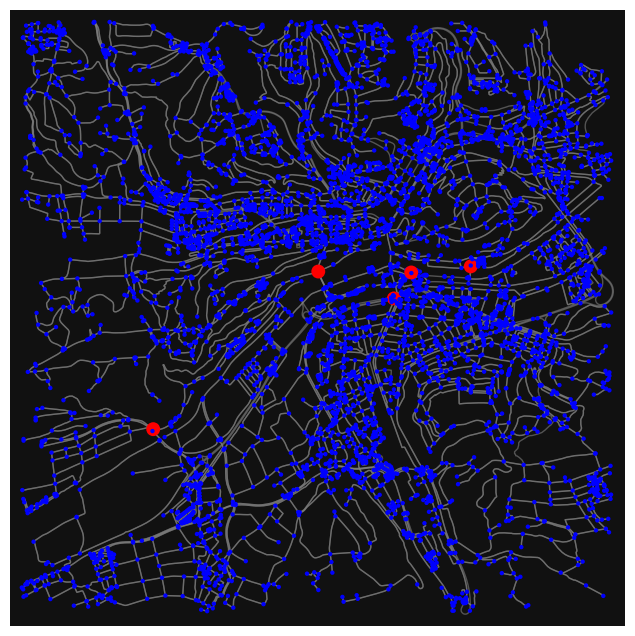

In [12]:
print(must_include_nodes)
node_colors = ['red' if n in must_include_nodes else 'blue' for n in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=[100 if n in must_include_nodes else 10 for n in G.nodes()],
    edge_color="gray",
    edge_alpha=0.6
)

In [13]:
all_lengths = {}
for site_node in must_include_nodes:
    lengths = nx.shortest_path_length(G, source=site_node, weight='length')
    all_lengths = lengths


all_lengths = dict(all_lengths)

drop_keys1 = [k for k, v in all_lengths.items() if v < 200]
for k in drop_keys1:
    all_lengths.pop(k)




In [14]:
min_dist_to_site = []
for n in G.nodes():
    dists = [all_lengths.get(n, np.inf) for site_node in must_include_nodes]
    min_dist_to_site.append(min(dists))
print(min_dist_to_site)

nodes['min_dist_to_site'] = min_dist_to_site
print(min(nodes['min_dist_to_site']))
nodes_finite = nodes[np.isfinite(nodes['min_dist_to_site'])].copy()
print(max(nodes_finite['min_dist_to_site']))

[np.float64(3481.938194717156), np.float64(2614.292327920462), np.float64(3015.736693791206), np.float64(2805.728567932322), np.float64(1935.546623506901), np.float64(2474.670721530453), np.float64(3898.558209793776), np.float64(3213.3313327994597), np.float64(5598.117700332401), np.float64(4495.9123602249465), np.float64(2309.436689501788), np.float64(3836.9614165186003), np.float64(6021.798591101403), np.float64(5323.438149500764), np.float64(4980.9922985049725), np.float64(4771.352241692478), np.float64(6368.5630389405305), np.float64(4474.370346087817), np.float64(2328.533907826068), np.float64(4838.548972739913), np.float64(1989.0160594960682), np.float64(2384.935536191752), np.float64(2546.9509794454907), np.float64(4520.749607769557), np.float64(4725.723230800463), np.float64(5103.041247446446), np.float64(3273.964917408814), np.float64(2789.471531034081), np.float64(2607.71059682177), np.float64(2225.6858547160705), np.float64(2632.1842424223605), np.float64(2236.2549679354756)

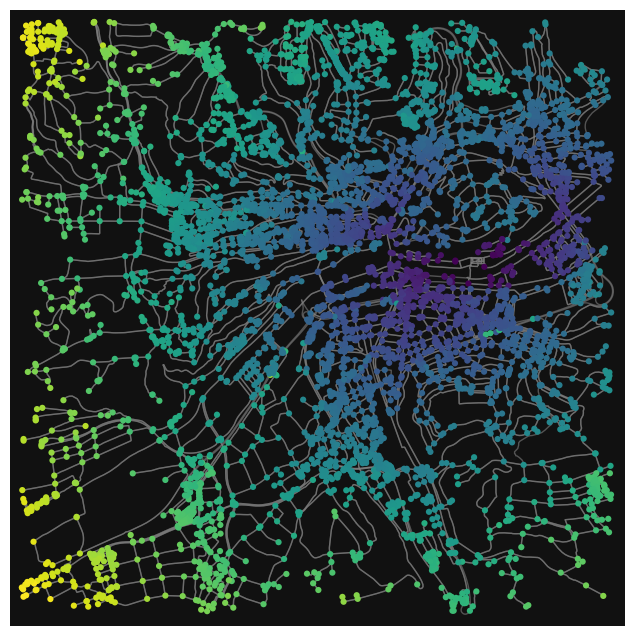

In [15]:
node_colors = nodes['min_dist_to_site'].values

fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=20,
    node_zorder=3,
    edge_color="gray",
    edge_alpha=0.6,
    show=True,
    close=False
)

This does not work yet ._.

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [17]:
nodes_finite = nodes[np.isfinite(nodes['min_dist_to_site'])].copy()
nodes_sampled = nodes_finite.sample(n=500, random_state=42) 
X = nodes_sampled[['x','y']].values
y = nodes_sampled['min_dist_to_site'].replace(np.inf, 5000).values

# GP Kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.005, length_scale_bounds=(1e-5, 1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=1e-2)

gp.fit(X, y)
y_pred, sigma = gp.predict(X, return_std=True)
nodes_sampled['gp_pred'] = y_pred
nodes_sampled['gp_std'] = sigma

c:\Users\Crabsi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 14 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Crabsi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


NameError: name 'existing_sites_nodes' is not defined

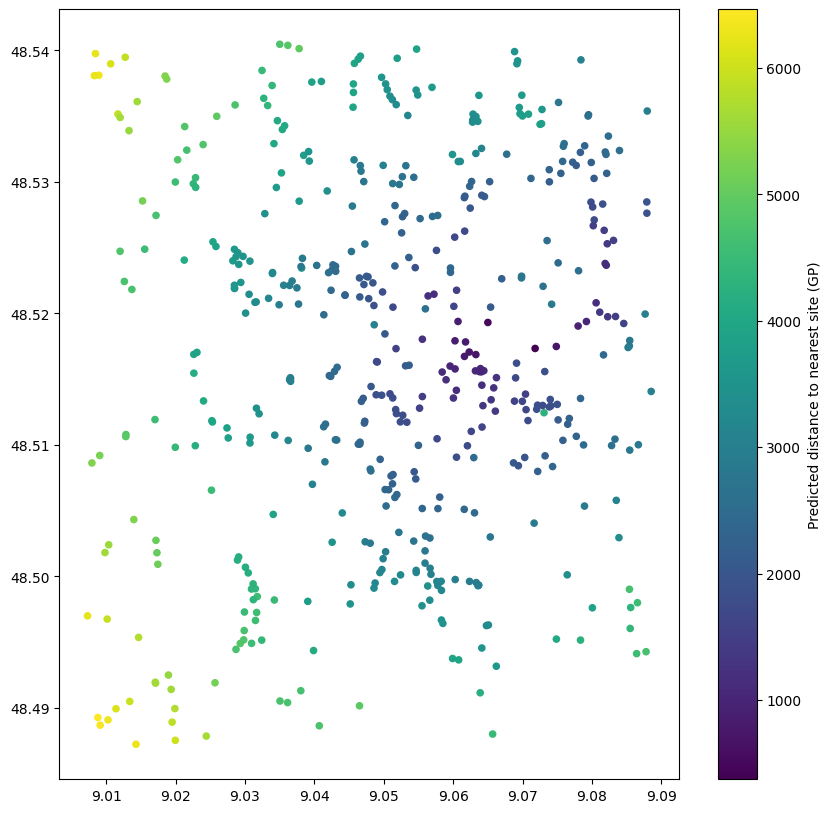

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(nodes_sampled['x'], nodes_sampled['y'], c=nodes_sampled['gp_pred'], cmap='viridis', s=20)
plt.colorbar(label='Predicted distance to nearest site (GP)')
# bestehende Sites markieren
existing_x = [nodes_finite.loc[n, 'x'] for n in existing_sites_nodes]
existing_y = [nodes_finite.loc[n, 'y'] for n in existing_sites_nodes]
plt.scatter(existing_x, existing_y, color='red', s=50, label='Existing Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Gaussian Process Prediction for Next Counter Sites')
plt.legend()
plt.show()